# PA005: High Value Customer Identification

# Passo 0.0 - Imports

In [1]:
import re
import inflection
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

from ydata_profiling import ProfileReport
from scipy.cluster import hierarchy as hc

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx
from sklearn import manifold as mn
from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.neighbors   import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from PIL import Image

from IPython.core.display import HTML
display( HTML( '<style>.container { width:95% !important; }</style>') )

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:95% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [3]:
df_raw = pd.read_csv('C:/Users/User/repos/pa_005/data/Ecommerce.csv')
df_raw = df_raw.drop('Unnamed: 8', axis =1)

# Passo 1.0 - Descrição dos dados

In [4]:
df1 = df_raw.copy()

## Rename columns

In [5]:
cols_old = df1.columns
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
df1.columns = cols_new

## Data dimensions

In [6]:
print('Number of rows: ', df1.shape[0])
print('Number of columns: ', df1.shape[1])

Number of rows:  541909
Number of columns:  8


## Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
df1.head(2)

invoice_no stock_code                         description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A  WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55      17850.0  United Kingdom
1     536365      71053                 WHITE METAL LANTERN         6    29-Nov-16        3.39      17850.0  United Kingdom

## Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [11]:
print('Missing data: {:.2f}%'.format(100*(df_missing.shape[0]/df1.shape[0])))

Missing data: 24.93%


In [12]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change dtypes

In [14]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [16]:
# Central tendency - mean, media
# Dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
st1 = num_attributes.agg([min, max, np.mean,np.median, np.std]).T
rg = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).rename(columns={0:'range'})
sk = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).rename(columns={0:'skew'})
kt = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).rename(columns={0:'kurtosis'})

met = pd.concat([st1, rg, sk, kt], axis=1)
met

min      max      mean  median         std      range        skew       kurtosis
quantity   -80995.00  80995.0  9.552250    3.00  218.081158  161990.00   -0.264076  119769.160031
unit_price -11062.06  38970.0  4.611114    2.08   96.759853   50032.06  186.506972   59005.719097

### Categorical Attributes

#### Invoice No

In [17]:
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

In [18]:
print('Total number of invoices = ',len(df_letter_invoice))
print('Quantity < 0 = ',len(df_letter_invoice[df_letter_invoice['quantity']<0]))

print('\nTodos os pedidos com letras no number of invoices tem quantidade negativa -> DEVOLUÇÕES')

Total number of invoices =  9291
Quantity < 0 =  9288

Todos os pedidos com letras no number of invoices tem quantidade negativa -> DEVOLUÇÕES


#### Stock Code

In [19]:
# stock_code
# cat_attributes['stock_code'].astype(int)

stock_code_1_str = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())
print( 'Stock code com pelo menos uma string: ', stock_code_1_str )

# Investigando apenas o stock_code
print('Únicos', cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique())

# Ação
## 1. Remove stock_code in ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS' 'B' 'CRUK']

Stock code com pelo menos uma string:  1124
Únicos ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


#### Country

In [20]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Netherlands       0.004375
Belgium           0.003818
Switzerland       0.003694
Portugal          0.002803
Australia         0.002323
Name: country, dtype: float64

In [21]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head(10)

country  customer_id
36  United Kingdom         7587
14         Germany           95
13          France           90
10            EIRE           44
31           Spain           31
3          Belgium           25
33     Switzerland           24
27        Portugal           20
19           Italy           15
16       Hong Kong           15

# Passo 3.0 - Filtragem de variáveis

In [22]:
df2=df1.copy()

In [23]:
# ====== Numerical Attributes ======

# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

In [24]:
print('df1 shape:', df1.shape)
print('df2 shape:', df2.shape)

print('df2_returns shape:', df2_returns.shape)
print('df2_purchase shape:', df2_purchases.shape)

df1 shape: (541909, 8)
df2 shape: (536139, 7)
df2_returns shape: (8728, 7)
df2_purchase shape: (527411, 7)


# Passo 2.0 - Feature Engineering

In [25]:
df3 = df2.copy()

## Feature Creation

In [26]:
# data reference
df_ref = df3.drop(columns=['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [27]:
df_ref.shape

(5786, 1)

### Gross Revenue

In [28]:
# Gross Revenue (Faturamento = quantity x price)
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_21540\4213913686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### Recency -  Day from last purchase

In [29]:
# Recency -  Day from last purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### Quantity of products purchased

In [30]:
# Frequency
df_prd = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_prd, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### Frequency Purchase

In [31]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### Number of returns

In [32]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# Passo 4.0 - EDA

In [33]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

In [34]:
df4.shape

(5695, 6)

## Univariate Analysis

**Notes**
1. Cluster coesos - separados
2. Métricas
    - Min, máximo, range (dispersão)
    - Média e mediana 
    - Desvio padrão e variância
    - Coeficiente de variação
  
3. Remover "bad users": 16446

In [35]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

## Bivariate Analysis

In [36]:
cols = ['customer_id']
df4_2 = df4.drop(cols, axis=1)

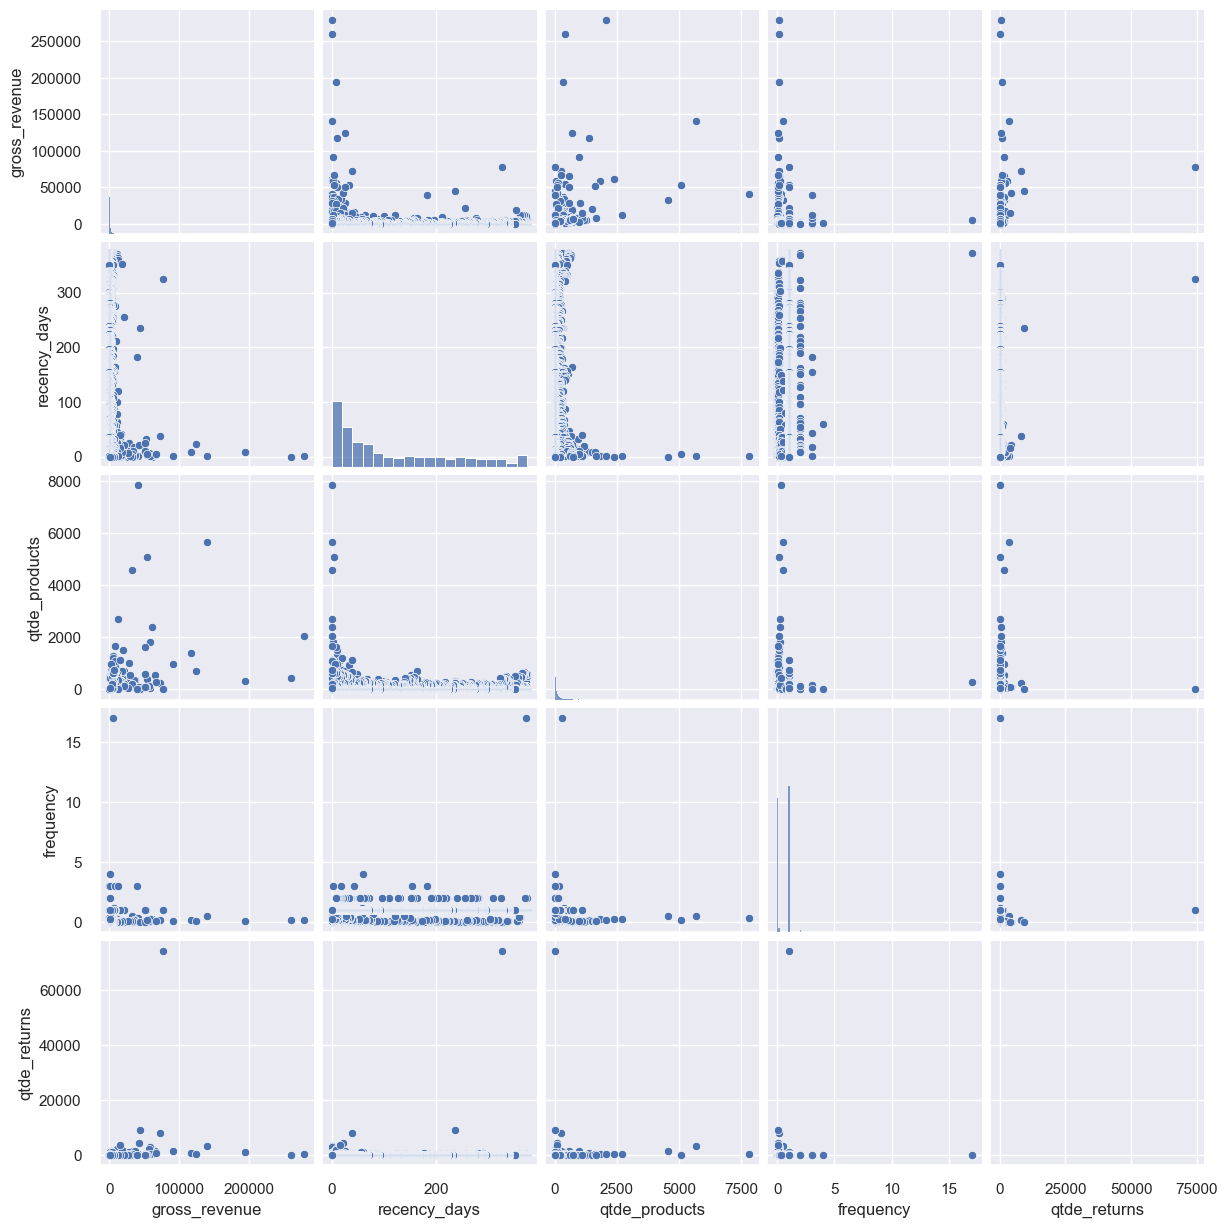

In [37]:
# plt.figure( figsize=(25, 12) )
# sns.pairplot( df4_2 )
Image.open( "imgs/pairplot.png" )

## Estudo de Espaço

In [40]:
# Selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df4_3 = df4[ cols_selected ].drop( columns='customer_id', axis=1 )

In [41]:
mm = pp.MinMaxScaler()

df4_3['gross_revenue']          = mm.fit_transform( df4_3[['gross_revenue']         ] ) 
# pickle.dump( mm , open( 'features/gross_revenue_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

df4_3['recency_days']           = mm.fit_transform( df4_3[['recency_days']          ] )
# pickle.dump( mm , open( 'features/recency_days_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

df4_3['qtde_products']           = mm.fit_transform( df4_3[['qtde_products']          ] )
# pickle.dump( mm , open( 'features/qtde_products_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

df4_3['frequency']              = mm.fit_transform( df4_3[['frequency']             ] )
# pickle.dump( mm , open( 'features/frequency_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

df4_3['qtde_returns']            = mm.fit_transform( df4_3[['qtde_returns']           ] )
# pickle.dump( mm , open( 'features/gqtde_returns_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )


X = df4_3.copy()

In [42]:
X.shape

(5695, 5)

### PCA

<BarContainer object of 5 artists>

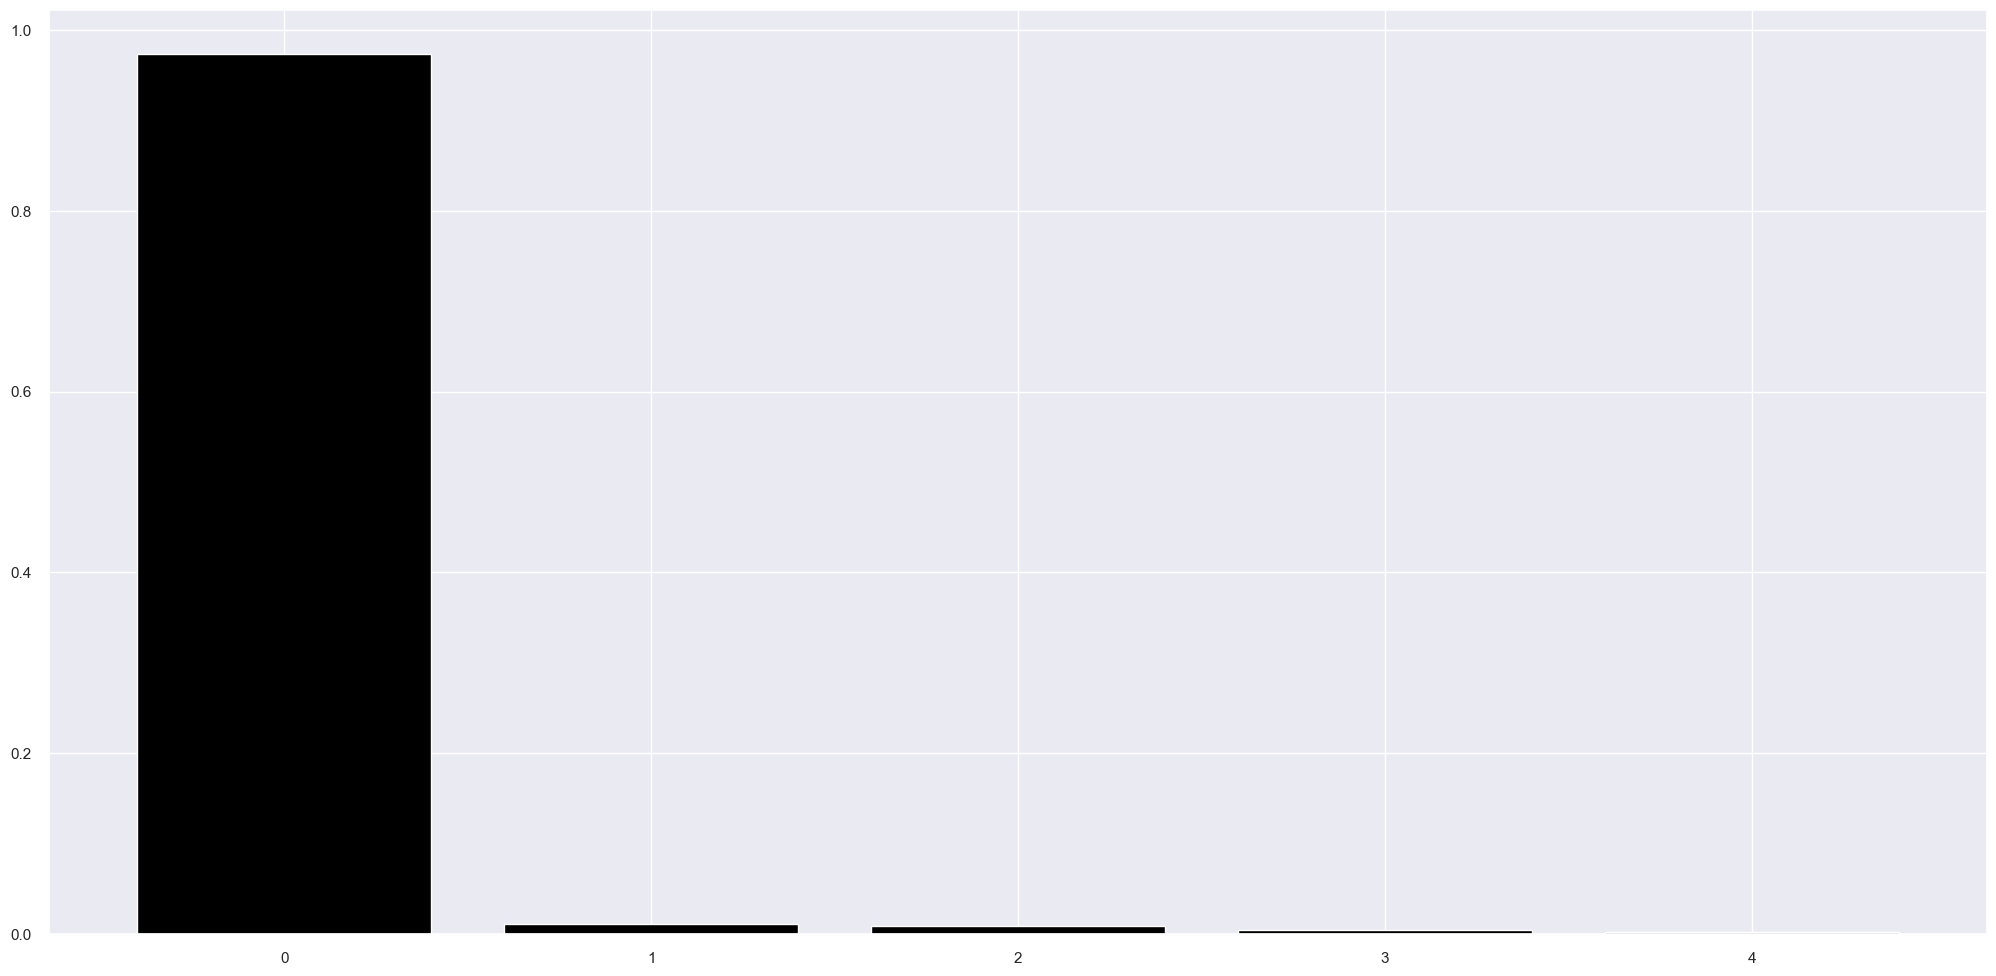

In [43]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

<AxesSubplot: xlabel='0', ylabel='1'>

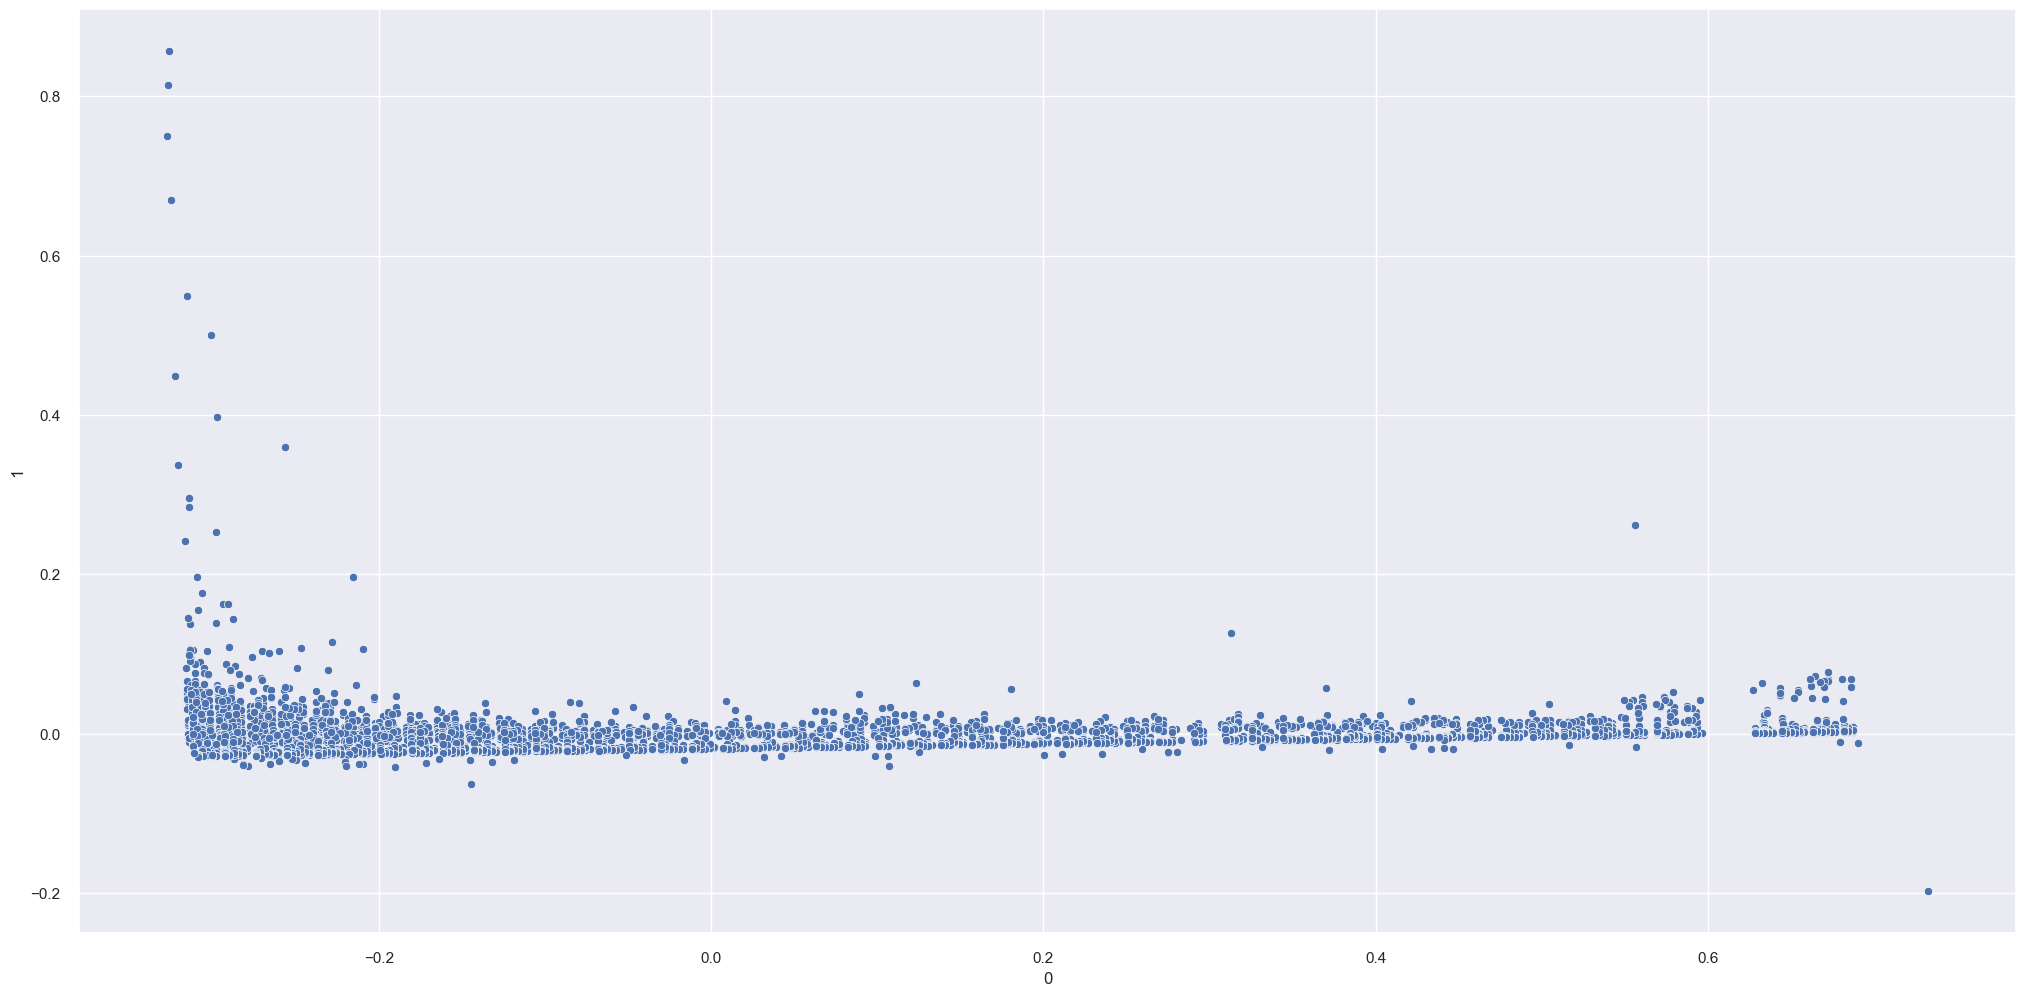

In [44]:
# pca component
df_pca = pd.DataFrame( principal_components )

sns.scatterplot( x=0, y=1, data=df_pca )

### UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

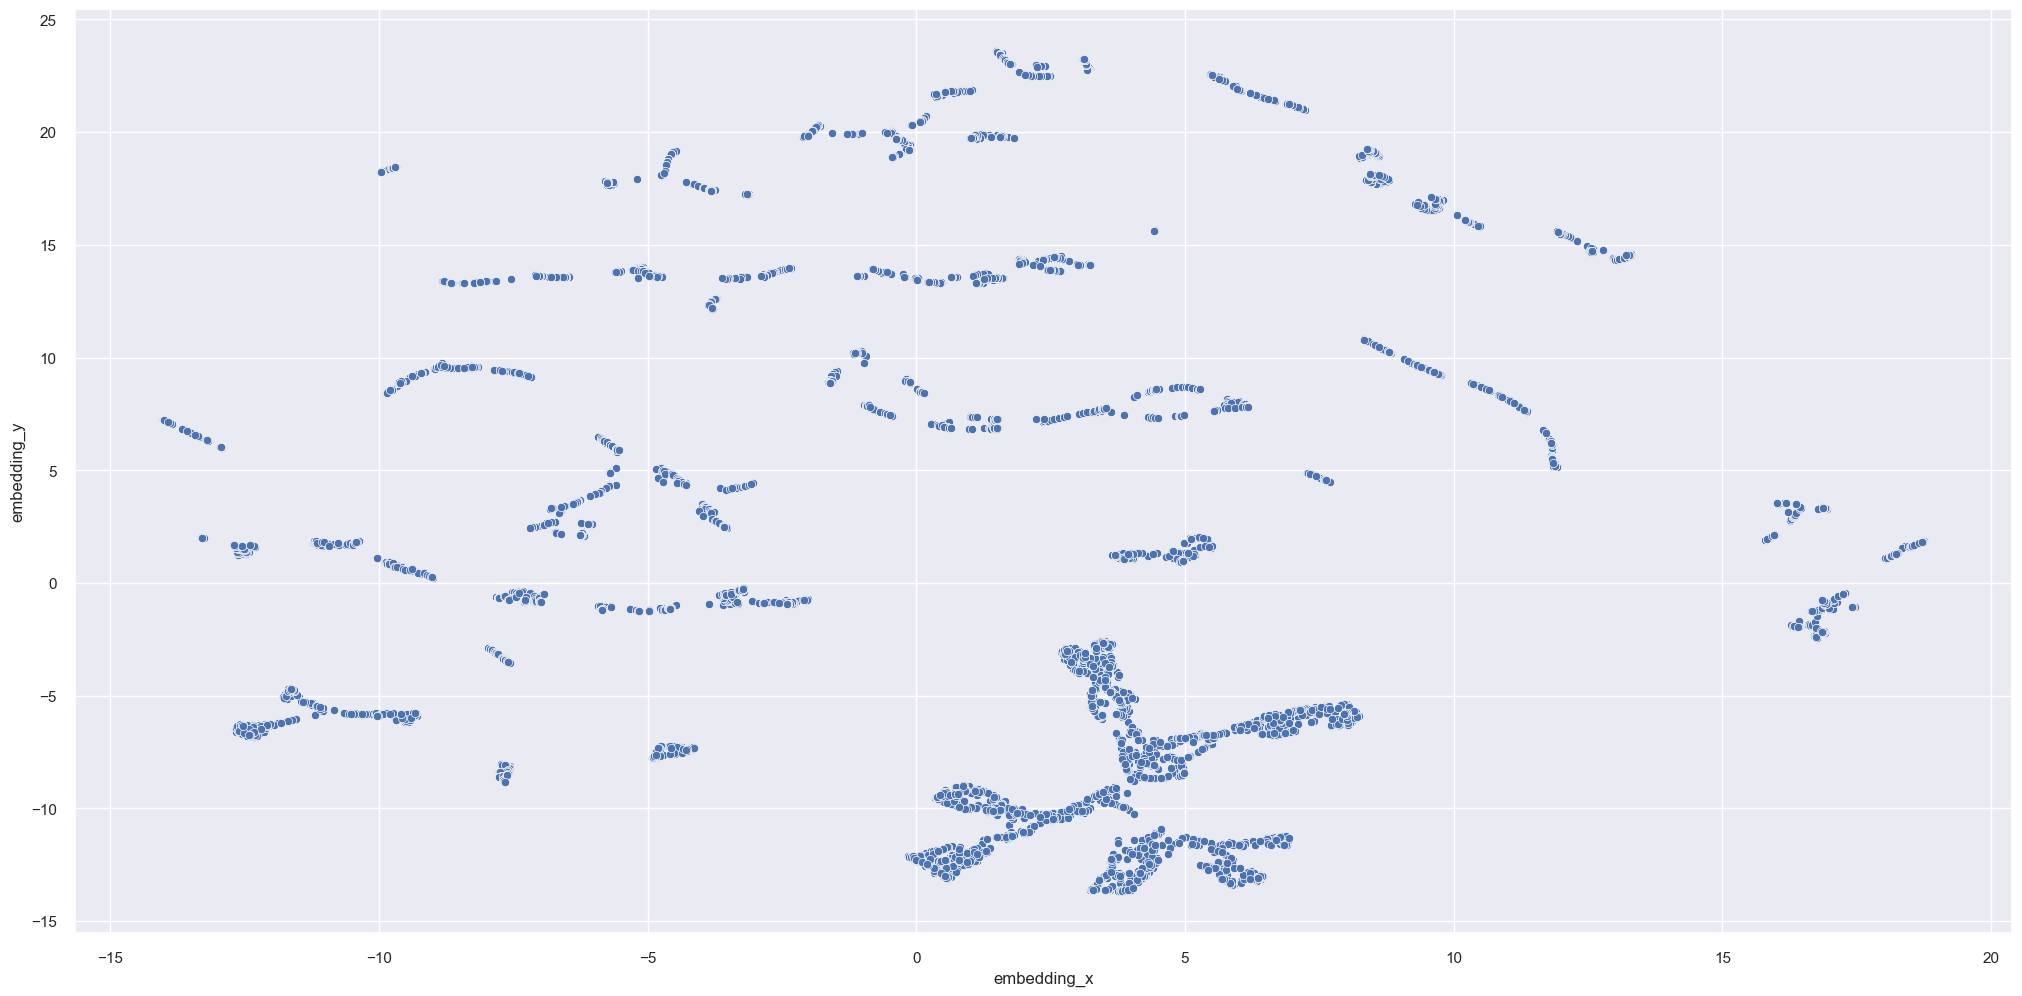

In [45]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

### t-SNE

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

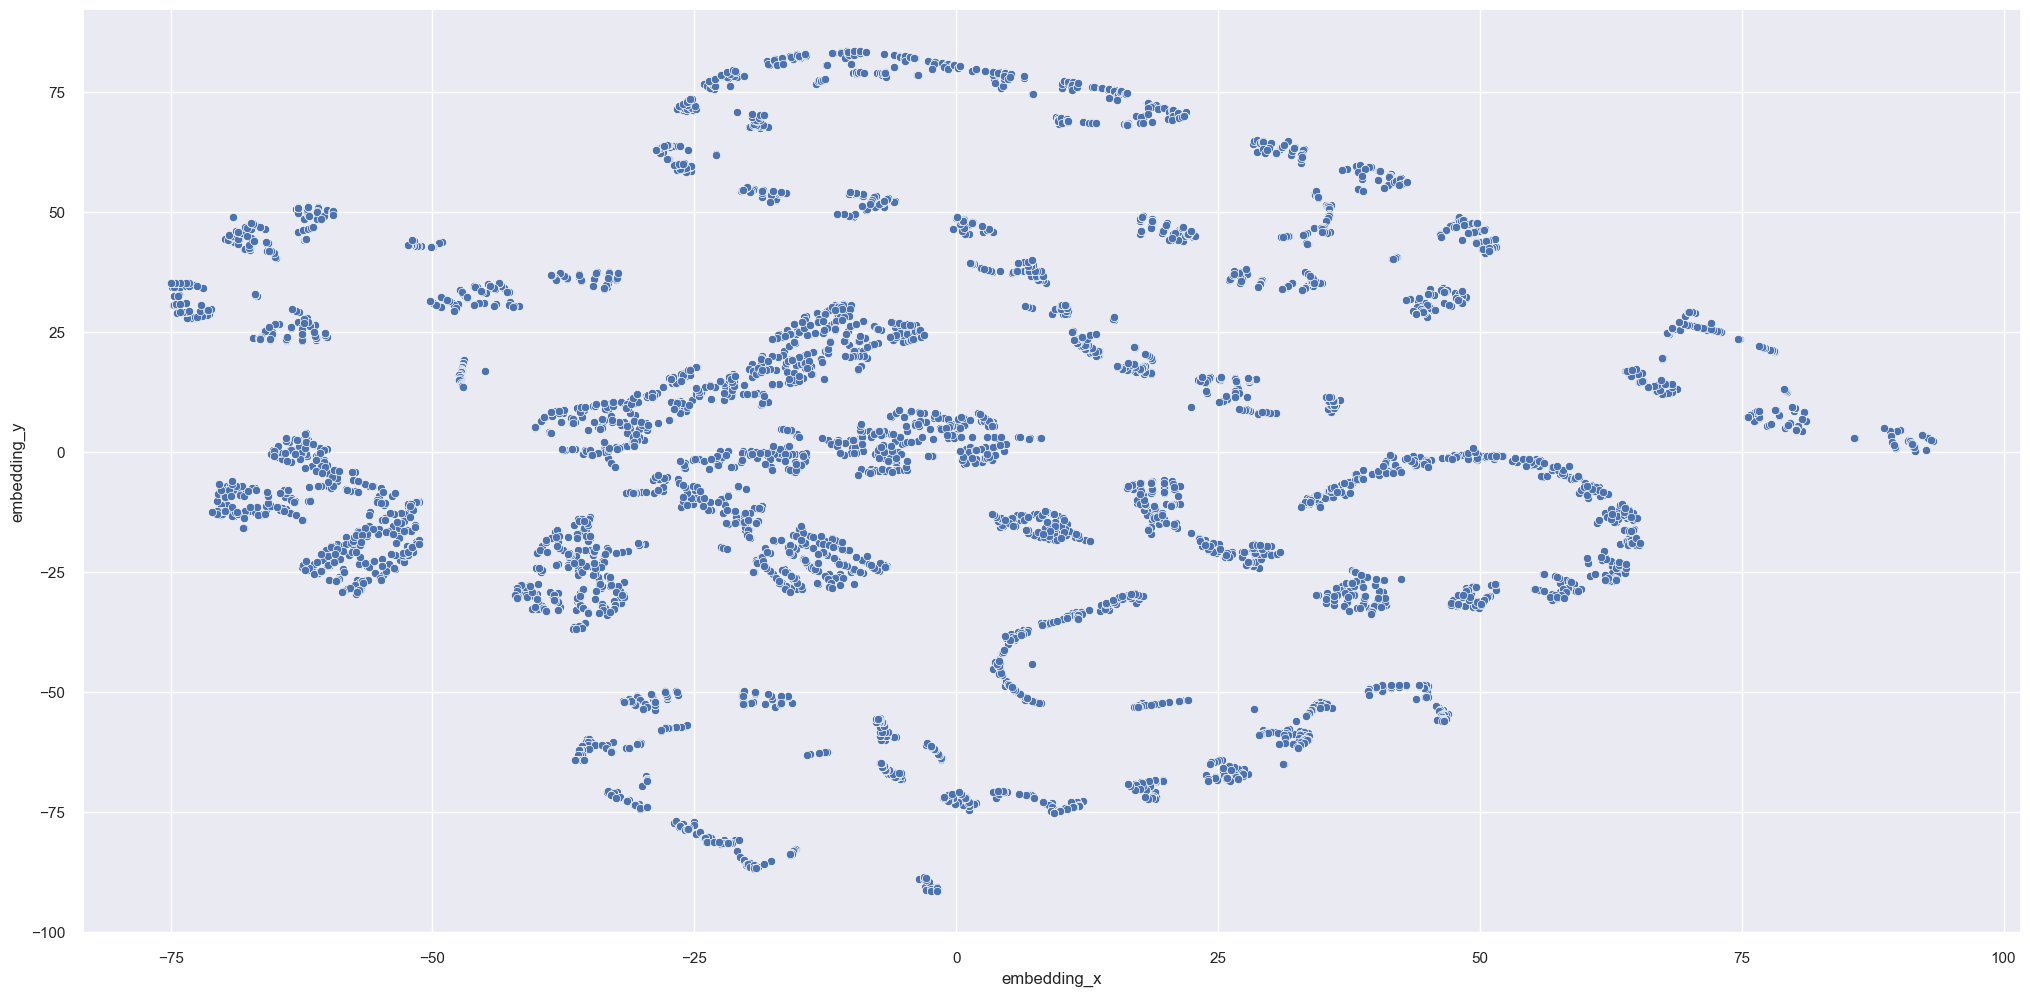

In [46]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

### Tree-Based Embedding

In [47]:
# training dataset
X = df4_3.drop( columns=['gross_revenue'], axis=1 )
y = df4_3['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )
pickle.dump( rf_model , open( 'C:/Users/User/repos/pa_005/src/models/rf_model.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

# Leaf 
# dataframe Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [48]:
X.shape

(5695, 4)

In [49]:
df_leaf.shape

(5695, 100)

In [50]:
df_leaf.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  6432  6889  6929  6404  6584  6824  6851  6937  6952  6502  6557  6447  6629  6800  6604  6419  6518  6749  6849  6882  6700  6780  6807  6937  6831  6827  6559  6659  6529  6645  6617  6639  6667  6544  6902  6981  6732  6957  6438  6894  6781  6487  6913  6601  6732  6529  6889  6839  6919  6947  6642  6820  6495  6437  6716  6912  6453  6635  6755  6427  6585  6836  6836  6584  6505  6920  6478  6603  6849  6933  6886  6877  6387  6498  6827  6697  6812  6530  6961  6899  6788  6812  6963  6558  6563  6847  6547  6861  6763  6539  6922  6519  7006  6720  6704  6645  6494  6536  6565  6836
1  6402  6189  6371  6314  6369  6551  6342  5646  6861  6316  6323  6335  6116  6760  6321  6315  6438  5971  6316  5870  6512  6197  6314  6319  5949  6065  6485  6548  6409  6638  6494  6496  6457  6466  6769  6823  5613  6818  6332  5948  6373  6410  6052  6470  6495  6301  6350  6309  6296  6717  6404  6338  6463  6388  5887  6748  6358  6400  6731  6379  6407  6769  6652  6531  6411  6282  6335  6525  6714  6547  6467  6294  6310  6430  6665  6570  5914  6400  6240  6260  6274  5672  6656  6485  6513  6662  6353  6783  5941  6458  6335  6293  6886  6325  6201  6205  6325  6404  6404  6531
2  5392  6459  6832  6393  6530  6767  6310  6827  6821  6914  6522  6437  6314  6792  6597  6397  6488  6784  6319  6826  6640  6272  6371  6462  6783  6753  6474  6939  6482  5522  6868  6640  6623  5462  6826  6895  6701  6868  6408  6820  5303  6435  6848  6555  6602  6479  6392  6467  6842  6748  6618  5072  6444  5662  6904  6816  6411  6543  6711  5243  6564  6814  6757  5689  6473  6384  6476  6553  6786  6868  6811  6359  6379  4962  6697  6643  6664  6519  6389  6424  6845  6716  6822  6531  6583  6726  6500  6853  6659  6491  6435  6405  6906  5705  6302  6582  6449  6374  6561  6775
3  2788   498   888   545   412   630   832   511   927   679  1022  1447  1321   933   974   654   570   977   592   582   505   315   903   642  1110   352   672  1041  1365   659   280  1071  1188   411   355   342   444   644  1161   344   784   498  1180   563   555   854   745   413   538   506   629  1194   608   487   517   357   964   419   991   435  1200   815   380   935   623   380   351   773   704   694   997  3215  1004   746  1071   592   429  1271  1072   999   738   388   610  1235   644  3048   328   715   850  1005  1234   697   857   539   962   726   632  1085   541   339
4   527   210   512   842   595  1684   501   967  1321   471   507   518  1654  1071   505   446   288   523   761   846   590   733   521   421  1519   421   504   646  1834   543  1157  1458   440   715   542   782  1578   537   461   628   471   752   561  1668   360   498   581   864   731   858   132  1280   423   670   124   804  1634   693   628   700   558   984   726   537    91   517   629   493  1115    45   154   541    87   273   298   501   681  1659   474   492   452  1491   703   464    84   454   797  1085  1496   553   411   953   456   782   530    74   541    92   688  1557

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

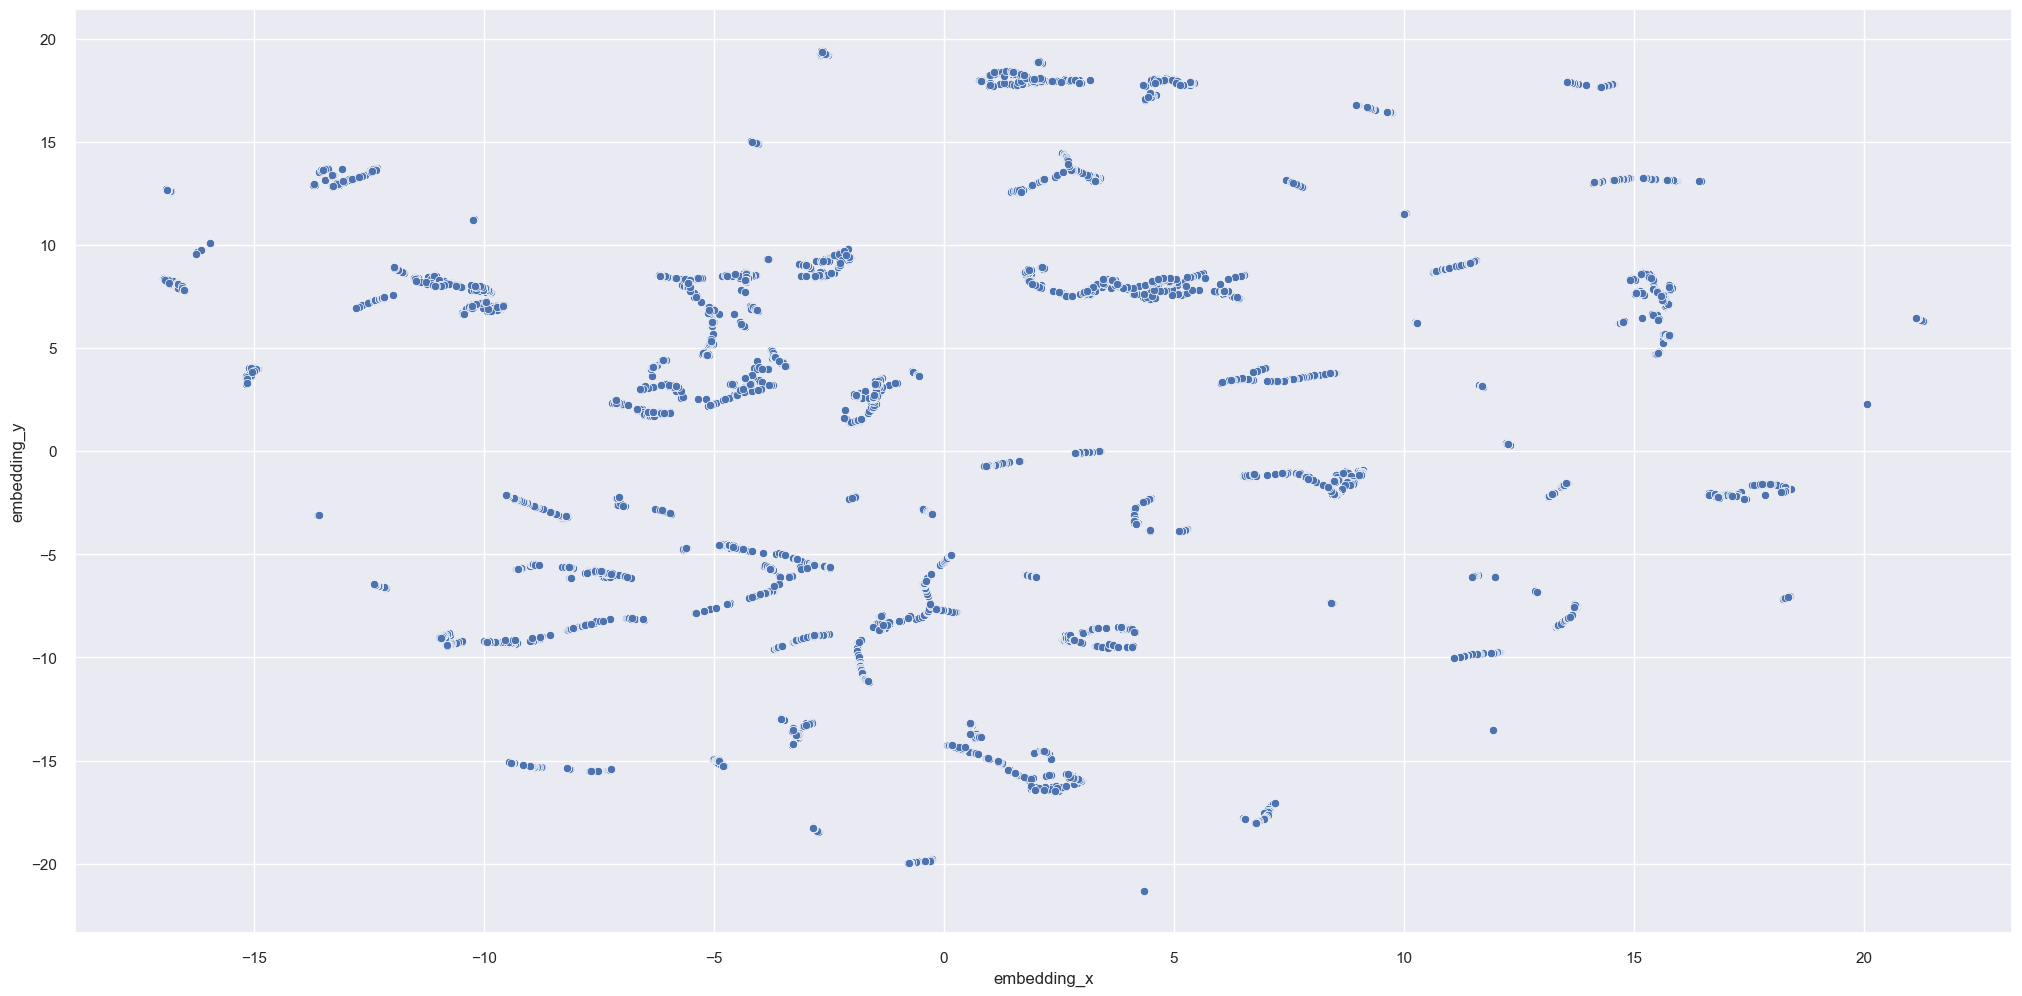

In [49]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

pickle.dump( reducer , open( 'C:/Users/User/repos/pa_005/src/features/umap_reducer.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree)

# Passo 5.0 - Data preparation

In [50]:
# Tree-Based Embedding
df5 = df_tree.copy()

In [51]:
df5.head()

embedding_x  embedding_y
0    -5.011420     6.911622
1    -6.555892     2.044689
2    -5.043211     6.324254
3    17.320278    -1.999133
4     8.423305    -7.343886

# Passo 7.0 - Hyperparameter fine-tuning

In [52]:
X = df5.copy()

In [53]:
X.head()

embedding_x  embedding_y
0    -5.011420     6.911622
1    -6.555892     2.044689
2    -5.043211     6.324254
3    17.320278    -1.999133
4     8.423305    -7.343886

In [54]:
cluster = np.arange(2,25,1)
cluster

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## K-Means

In [55]:
kmeans_list=[]

for k in cluster:    
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)#(init='random', n_clusters=4, n_init=10, max_iter =300, random_state=42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

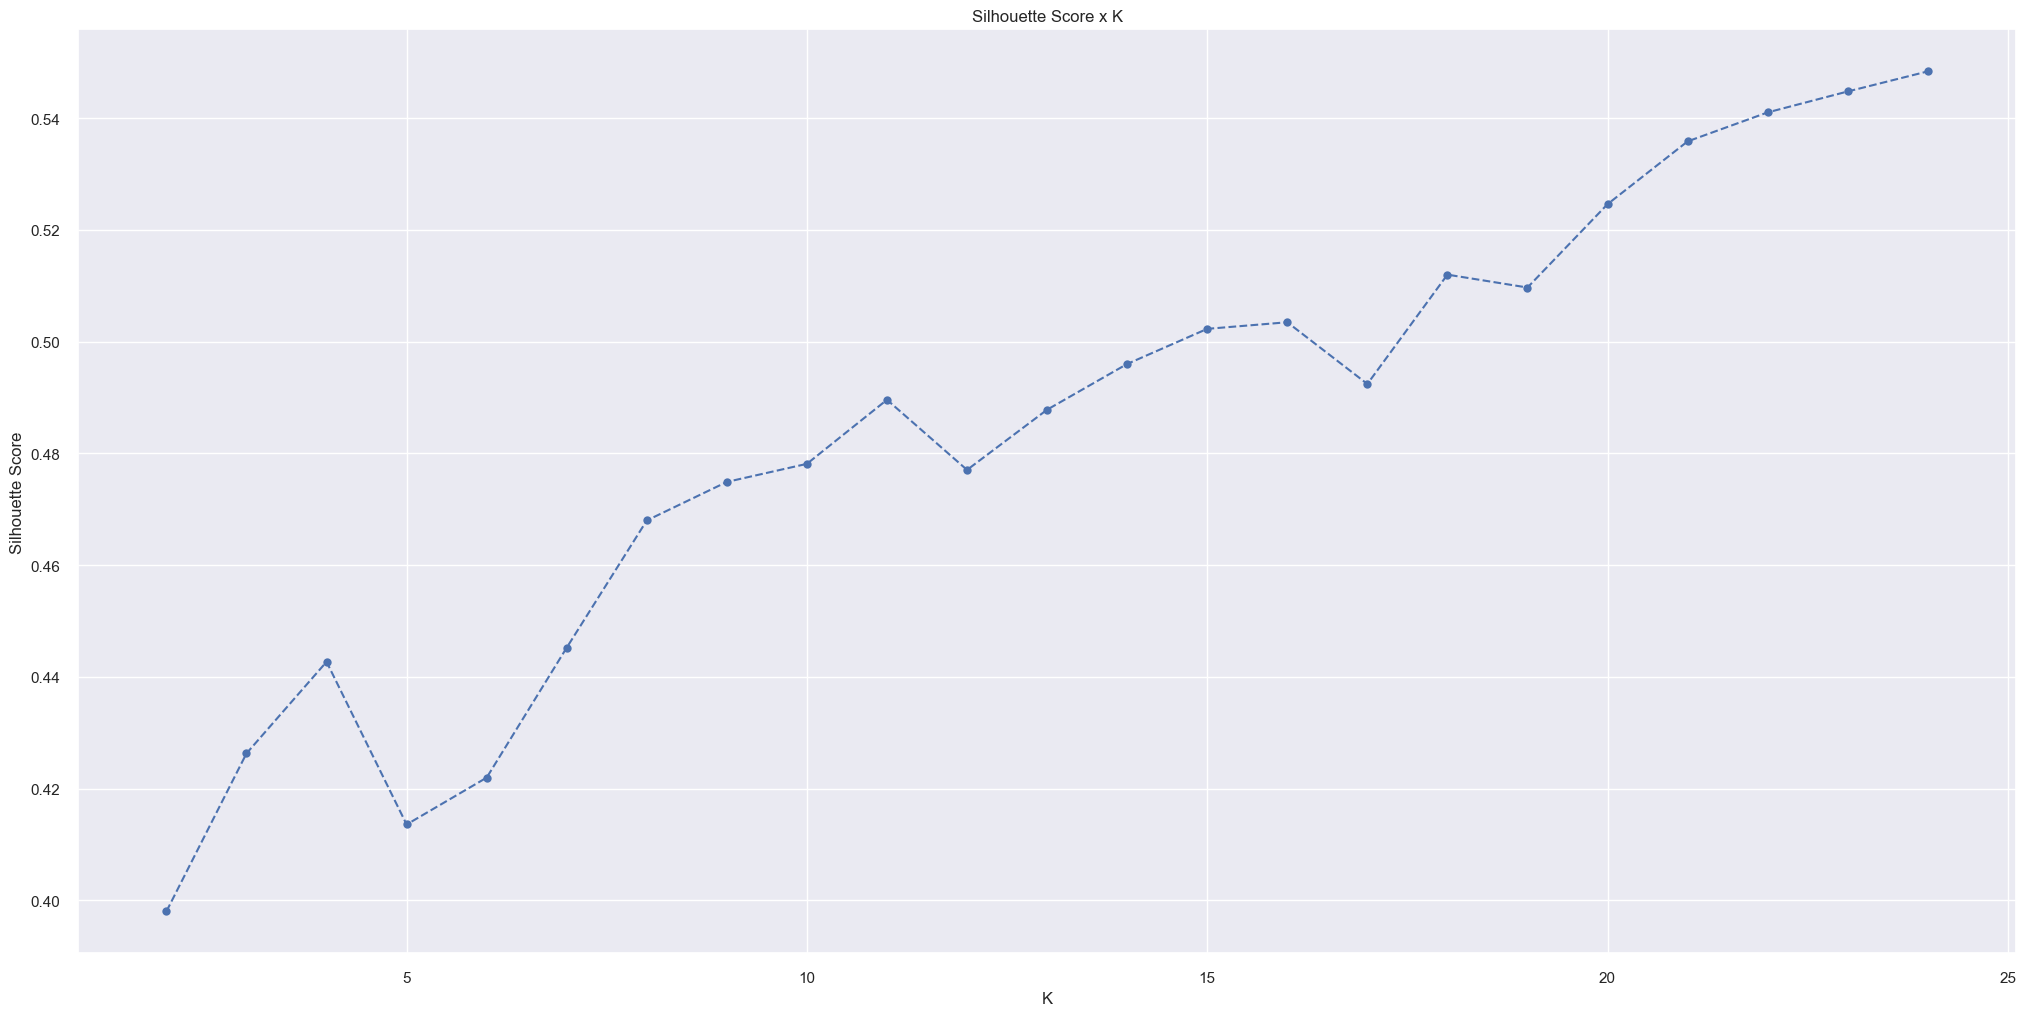

In [56]:
plt.plot(cluster, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## GMM

In [57]:
gmm_list=[]

for k in cluster:    
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

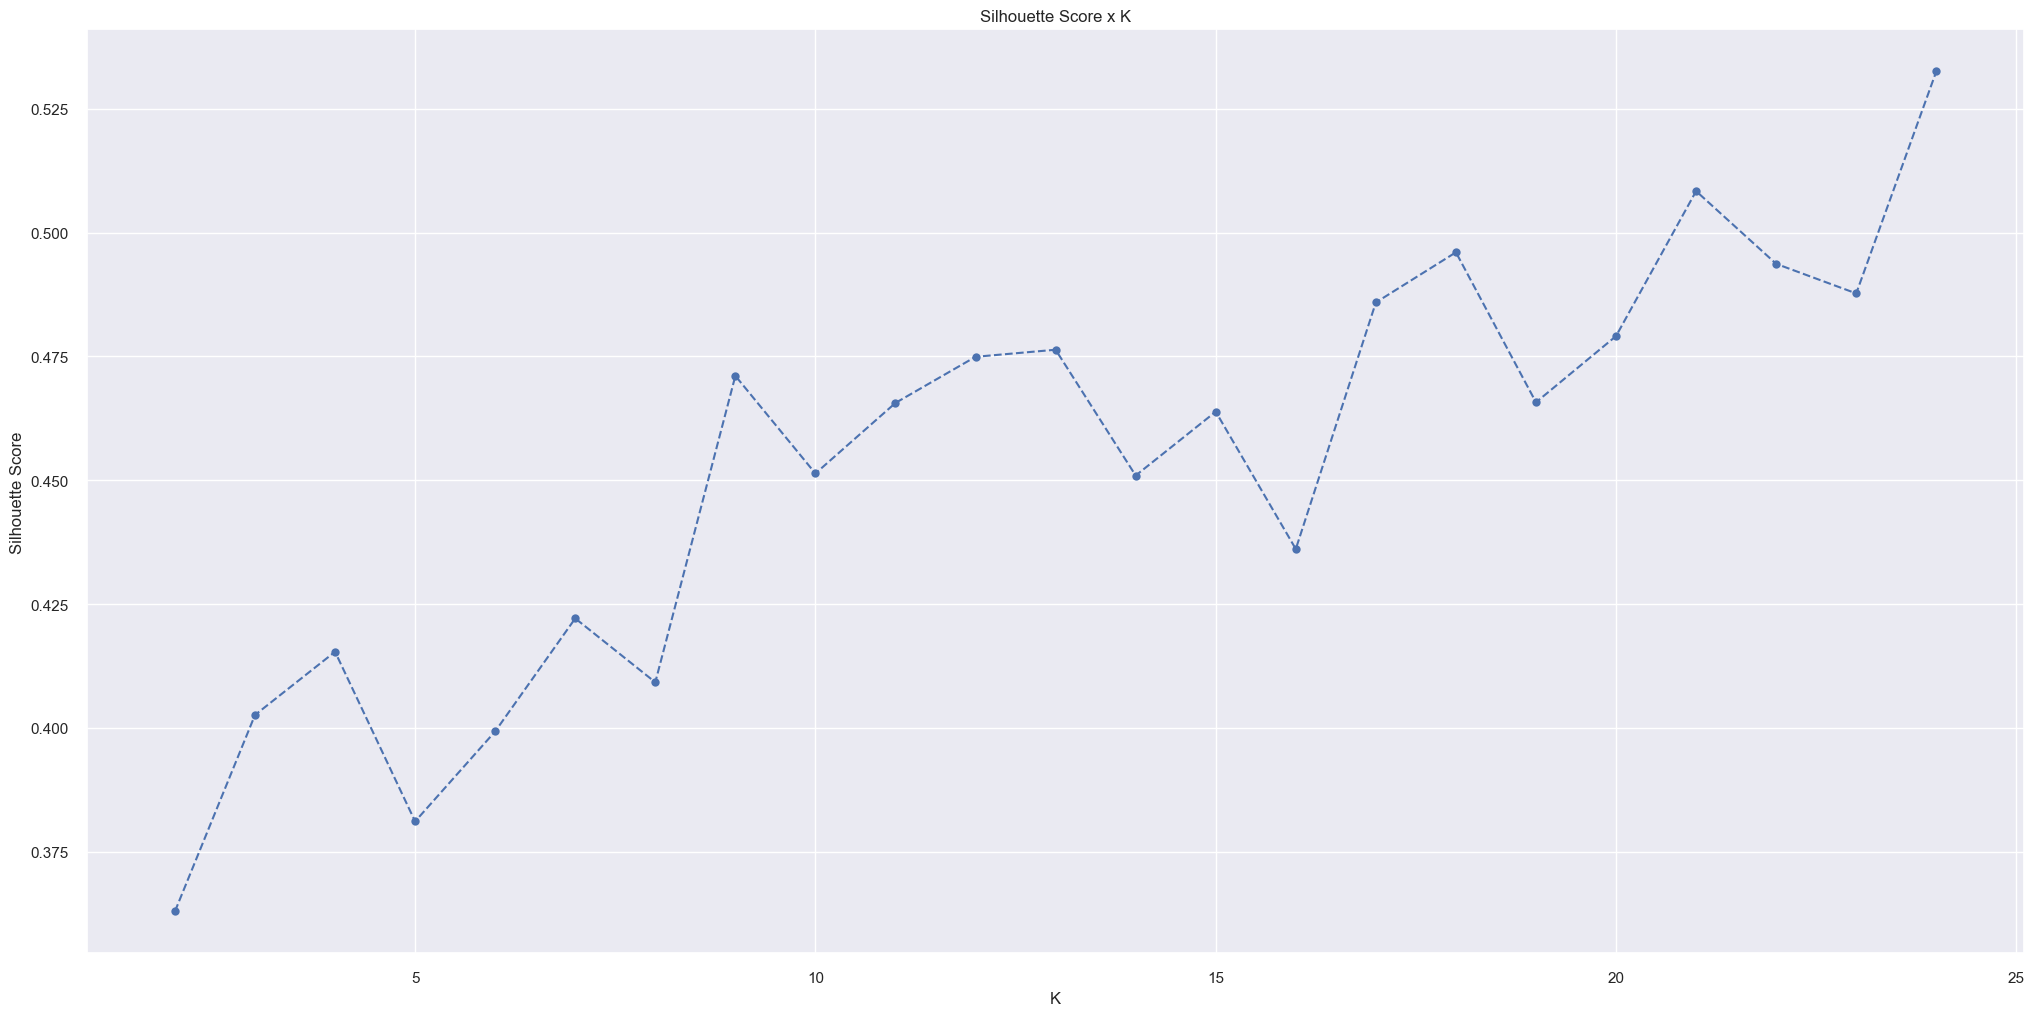

In [58]:
plt.plot(cluster, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## Hierarchical Clustering

In [59]:
hc_model = hc.linkage(X, method='ward')

[]

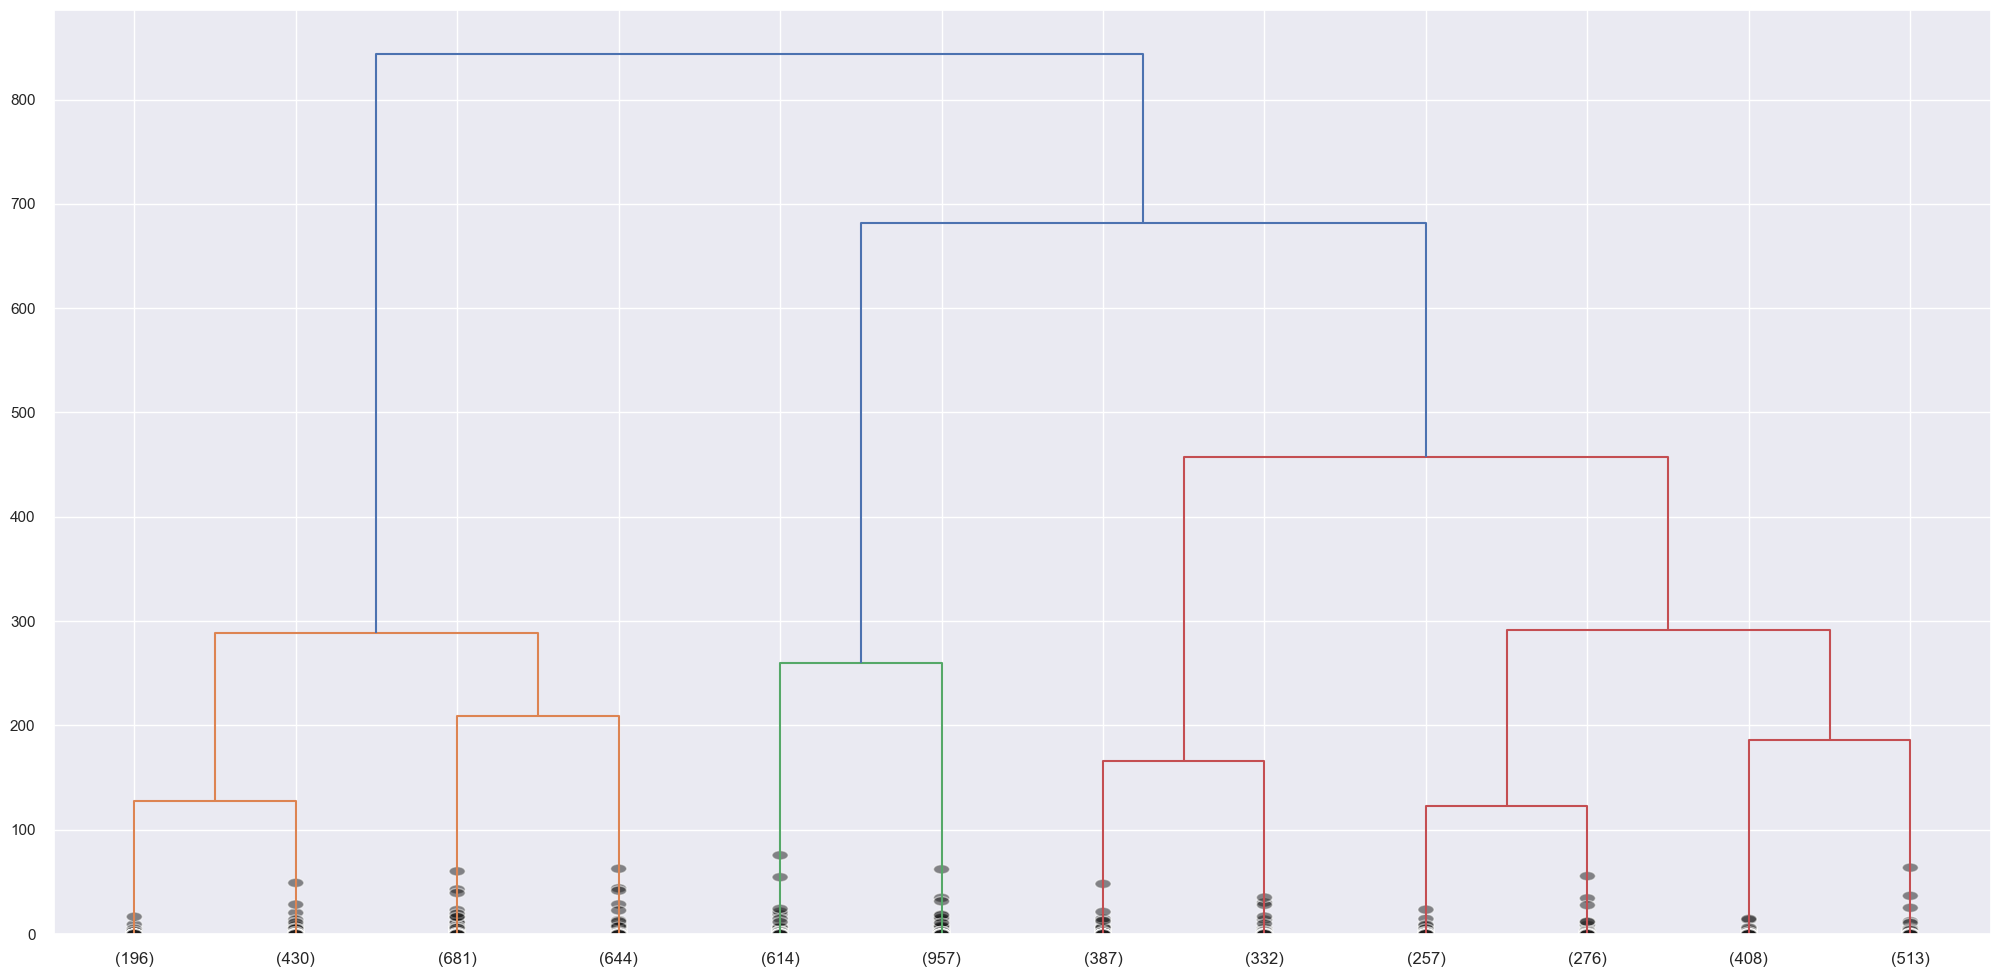

In [60]:
hc.dendrogram(hc_model, truncate_mode='lastp',p=12, show_contracted=True)

plt.plot()

### HClustering Silhouette Score

In [61]:
hc_list=[]
for k in cluster:
    # model definition & training
    hc_model = hc.linkage(X, method='ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

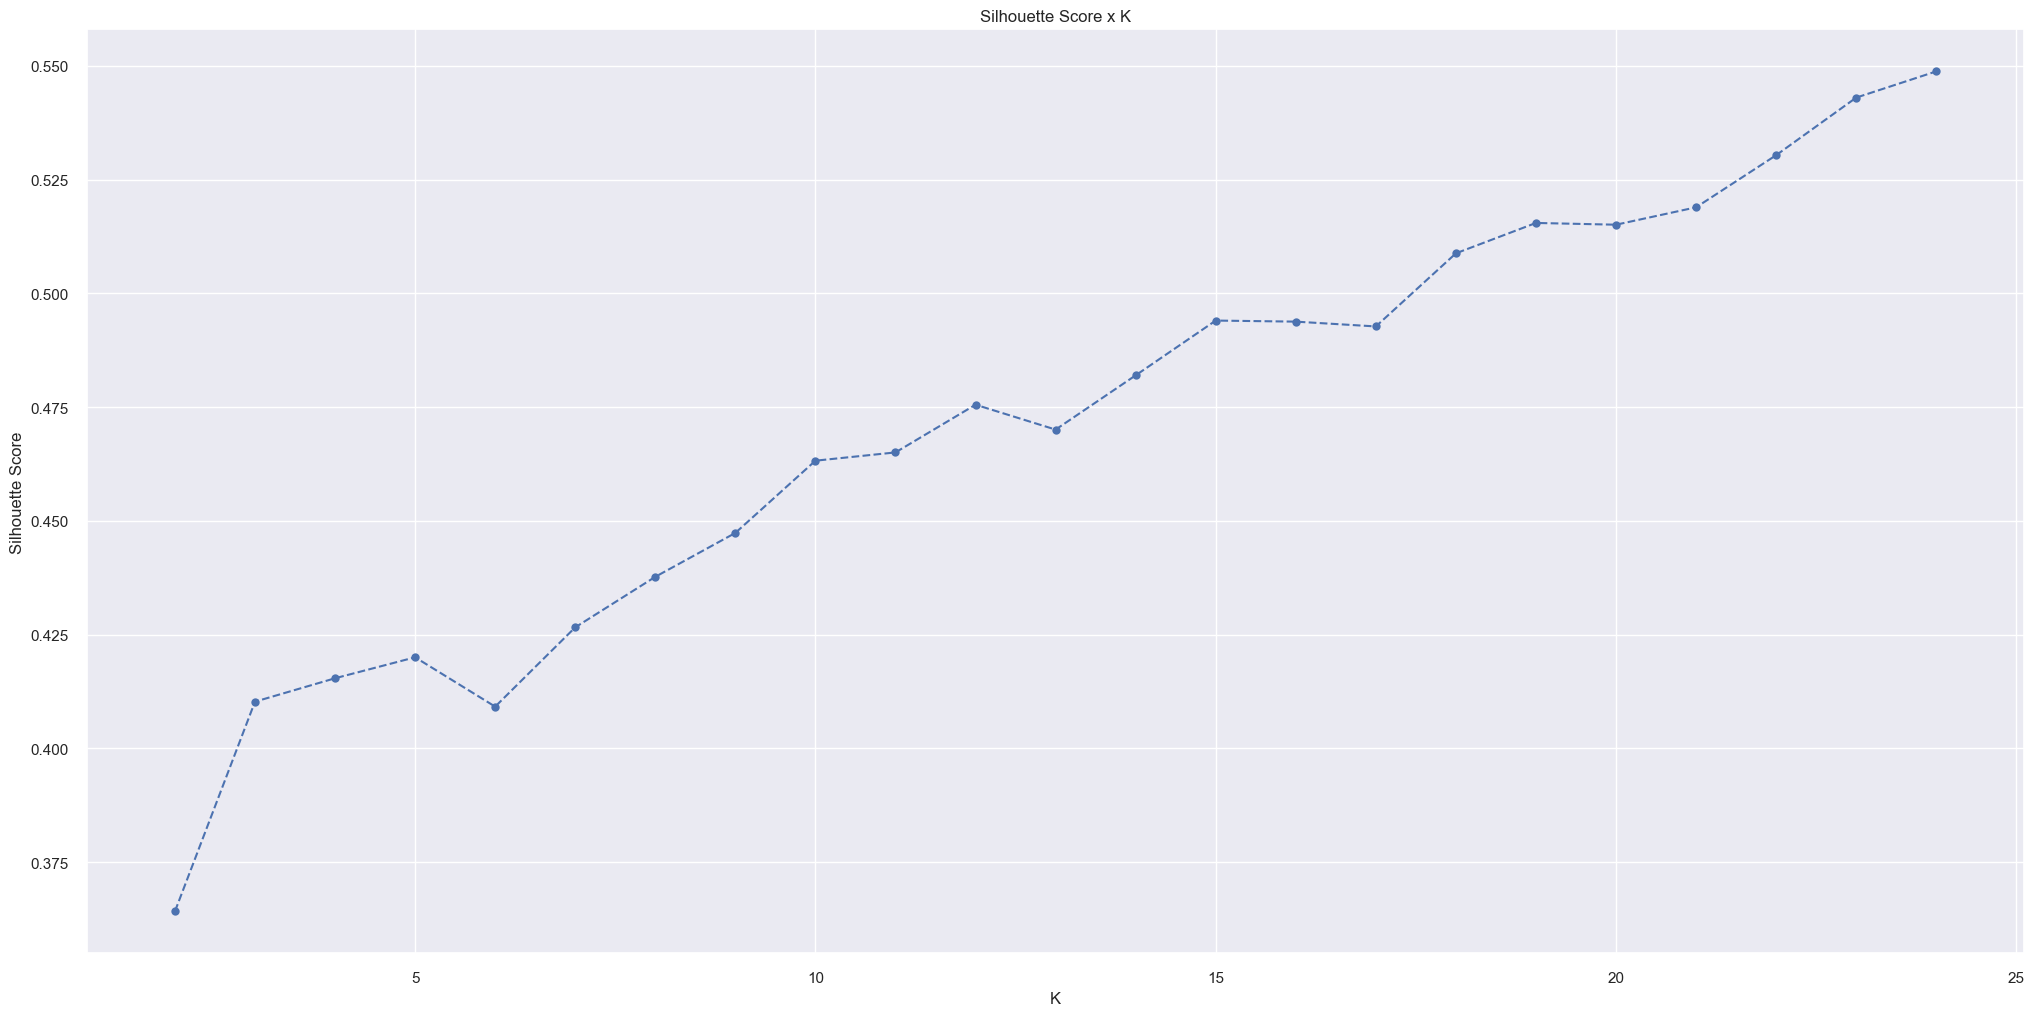

In [62]:
plt.plot(cluster, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## Results

In [63]:
df_results = pd.DataFrame({'KMeans':kmeans_list, 'GMM':gmm_list, 'Hiearchical': hc_list}).T
df_results.columns = cluster

In [64]:
df_results.style.highlight_max(color='lightgreen', axis=1)

# Passo 8.0 - Model training

## Final model - KMeans

In [65]:
# model definition
k=8
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter =300, random_state=42)

# model training
kmeans.fit(X)
pickle.dump( kmeans , open( 'models/kmeans_model.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL )

# clustering
labels = kmeans.labels_

## Cluster validation

In [66]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS
print( 'SS value: ', m.silhouette_score(X, labels, metric='euclidean'))

WSS value: 105118.421875
SS value:  0.467999


## Visualization Inspection

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


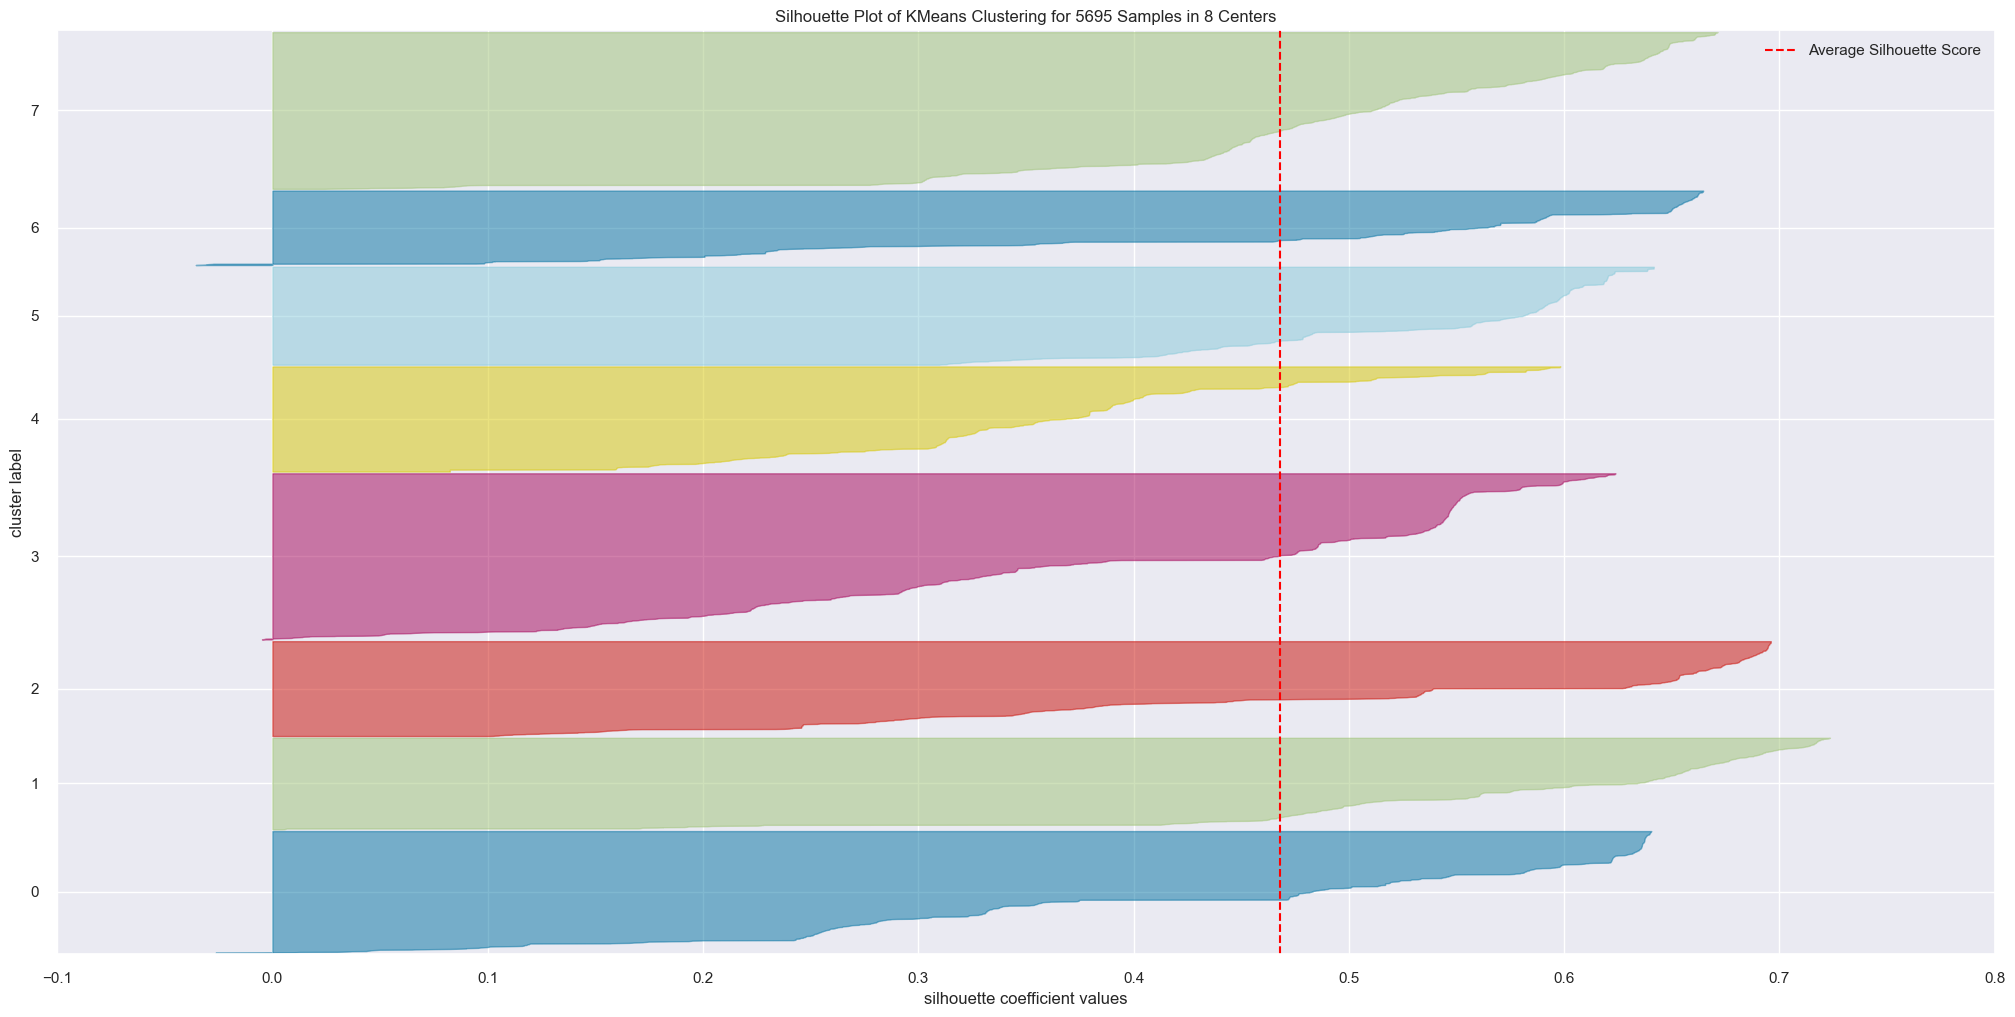

In [67]:
# Silhouette Analysis
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

# Passo 9.0 - Cluster Analysis

In [68]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

embedding_x  embedding_y  cluster
0    -5.011420     6.911622        7
1    -6.555892     2.044689        7
2    -5.043211     6.324254        7
3    17.320278    -1.999133        4
4     8.423305    -7.343886        4

## Visualization Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

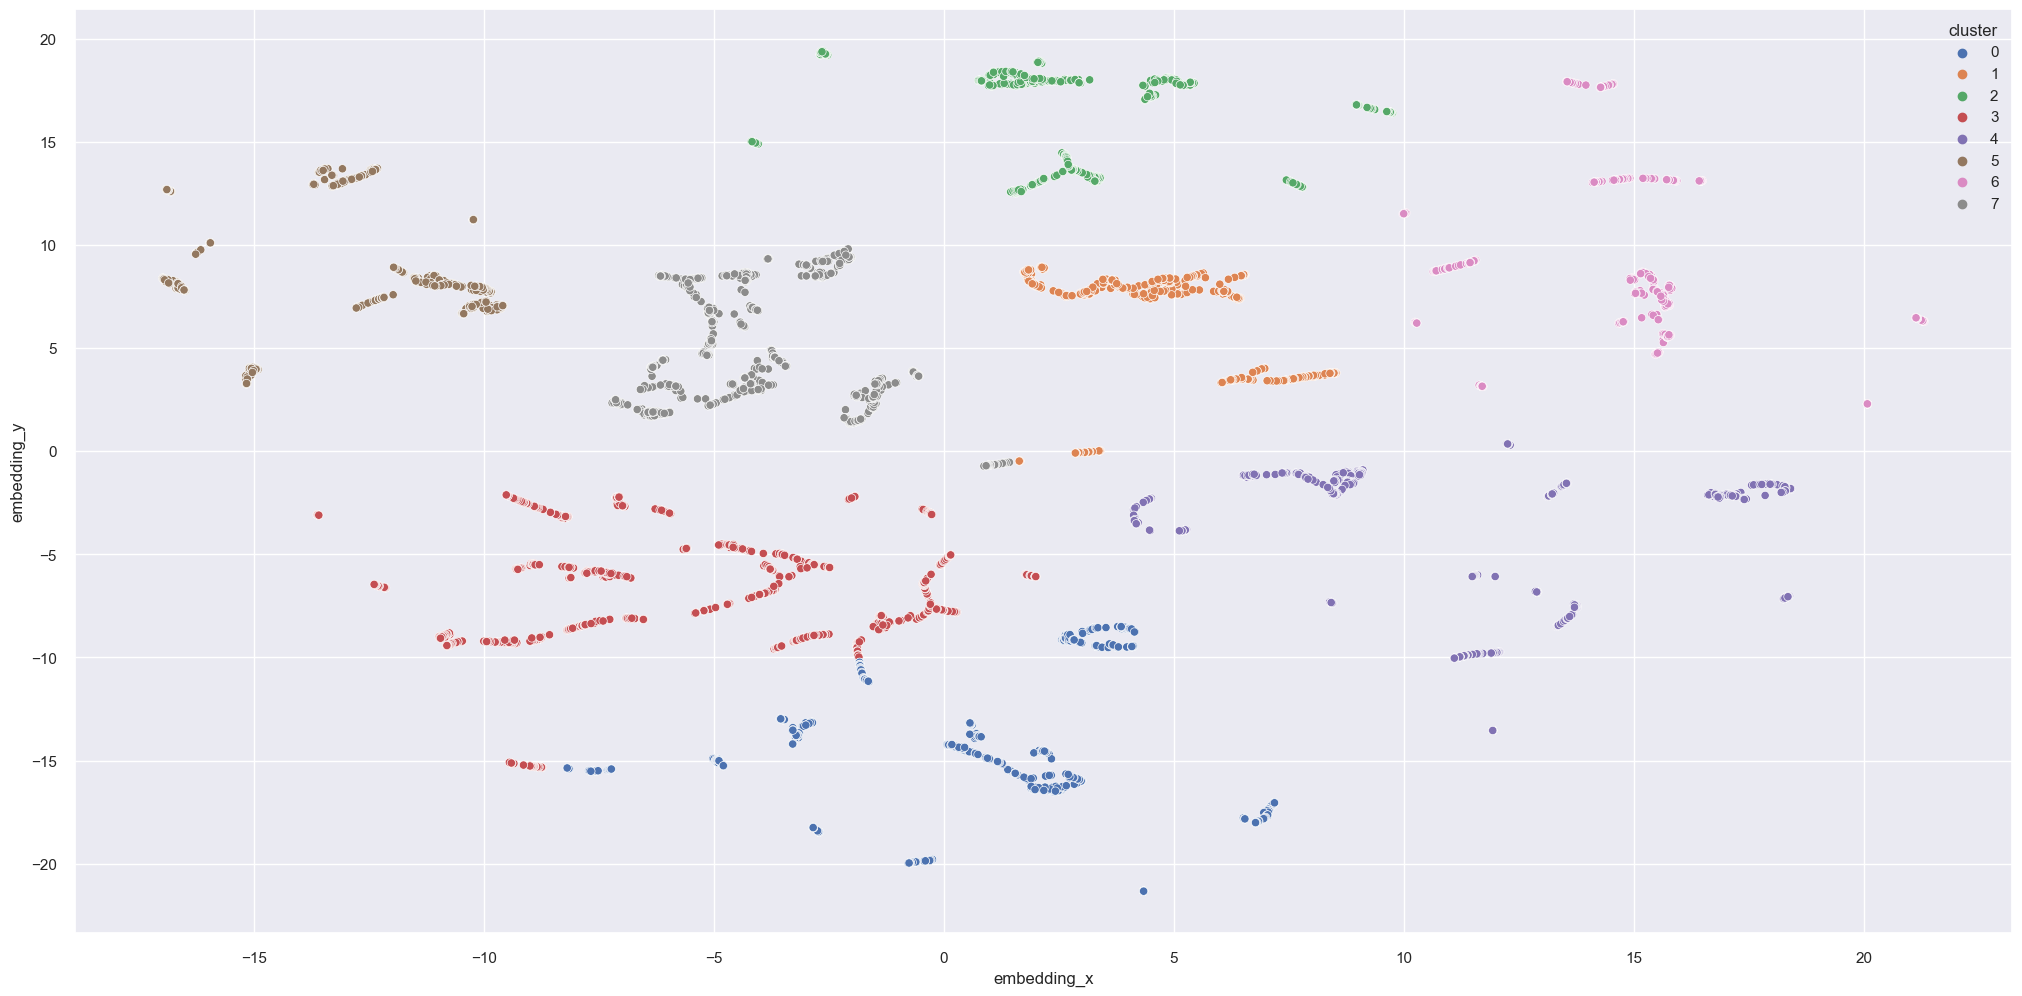

In [69]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data = df9, palette='deep')

## Cluster Profile

In [70]:
df9_2 = df4[ cols_selected ].copy()
df9_2['cluster'] = labels
df9_2.head()

customer_id  gross_revenue  recency_days  qtde_products  frequency  qtde_returns  cluster
0        17850        5391.21         372.0          297.0  17.000000          40.0        7
1        13047        3232.59          56.0          171.0   0.028302          35.0        7
2        12583        6705.38           2.0          232.0   0.040323          50.0        7
3        13748         948.25          95.0           28.0   0.017921           0.0        4
4        15100         876.00         333.0            3.0   0.073171          22.0        4

In [71]:
# Number of customers
df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

# Avg 'gross_revenue'
df_avg_gross_revenue = df9_2[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on='cluster', how='inner')

# Avg 'recency_days'
df_avg_recency_days = df9_2[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')

# Avg 'qtde_products'
df_avg_invoice_no = df9_2[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, on='cluster', how='inner')

# Avg 'frequency'
df_avg_ticket = df9_2[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

# Avg 'qtde_returns'
df_avg_ticket = df9_2[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

df_cluster.sort_values('gross_revenue', ascending=False)

cluster  customer_id  perc_customer  gross_revenue  recency_days  qtde_products  frequency  qtde_returns
7        7          982      17.243196    5760.254695     59.318737     309.126273   0.299594    157.691446
5        5          614      10.781387    1681.132590    108.530945      96.718241   0.375450      9.669381
1        1          574      10.079017    1656.614547     90.886760     106.681185   0.524446      0.261324
2        2          595      10.447761    1060.557311     97.299160      48.315966   0.344852      6.556303
4        4          659      11.571554     780.888892    157.863429      48.978756   0.690955      6.059181
3        3         1041      18.279192     687.171883    164.471662      19.195965   0.950579      6.816523
6        6          467       8.200176     569.271499    143.554604      23.408994   0.528161      2.828694
0        0          763      13.397717     443.175596    116.205767      14.795544   0.516859      1.077326

  
**Cluster 7** - _Príncipe_

    - Número de customers: 982 ( 17,24% dos customers)
    - Faturamento médio: $ 5760 dólares
    - Recência em média: 59 dias
    - Média de produtos comprados: 309
    - Frequência de produtos comprados: 0.30
    - Média quantidade de devoluções: 157

# EDA - Cluster Principe

In [74]:
df10 = df9_2.copy()

In [75]:
# Name cluster
cluster_map = {7:'Principe', 5:'Duque', 1:'Marques', 2:'Conde', 4:'Visconde', 3:'Barao', 6:'Burgues', 0:'Plebeu'}
df10['cluster_name'] = df10['cluster'].map(cluster_map)

## Faturamento - gross_revenue

In [76]:
aux = df10[['gross_revenue','cluster_name']].groupby('cluster_name').sum().reset_index()
px.bar(aux, x='cluster_name', y='gross_revenue', color='cluster_name')

In [77]:
print('Faturamento dos clientes do cluster Príncipe corresponde a {:.2f}% do total'.format(round(100*(df10.loc[df10['cluster_name']=='Principe','gross_revenue'].sum() / aux['gross_revenue'].sum()),2)))

Faturamento dos clientes do cluster Príncipe corresponde a 55.98% do total


## Quantidade de produtos comprados

In [78]:
aux = df10[['qtde_products','cluster_name']].groupby('cluster_name').sum().reset_index()
px.bar(aux, x='cluster_name', y='qtde_products', color='cluster_name')

In [79]:
print('Os clientes do cluster Príncipe possuem um volume de produtos de {:.2f}% do total'.format(round(100*(df10.loc[df10['cluster_name']=='Principe','qtde_products'].sum() / aux['qtde_products'].sum()),2)))

Os clientes do cluster Príncipe possuem um volume de produtos de 57.56% do total


## Média de devoluções

In [82]:
aux = df10[['qtde_returns','cluster_name']].groupby('cluster_name').mean().reset_index()
px.bar(aux, x='cluster_name', y='qtde_returns', color='cluster_name')

In [83]:
print('Os clientes do cluster Príncipe possuem média de devolução de {:.2f}% enquanto a média da base é {:.2f}%'.format(round(df10.loc[df10['cluster_name']=='Principe','qtde_returns'].mean(),2), round(df10.loc[:,'qtde_returns'].mean(),2)))

Os clientes do cluster Príncipe possuem média de devolução de 157.69% enquanto a média da base é 31.27%


## Mediana do faturamento

In [84]:
aux = df10[['gross_revenue','cluster_name']].groupby('cluster_name').median().reset_index()
px.bar(aux, x='cluster_name', y='gross_revenue', color='cluster_name')

In [85]:
median_pr = df10.loc[df10['cluster_name']=='Principe','gross_revenue'].median()
median_all = df10.loc[:,'gross_revenue'].median()
print('A mediana dos clientes do cluster Príncipe é {:.2f} enquanto a mediana da base é {:.2f}, ou seja {:.2f}x maior. '.format(round(median_pr,2), round(median_all,2), round(median_pr / median_all,2)))

A mediana dos clientes do cluster Príncipe é 2826.31 enquanto a mediana da base é 613.20, ou seja 4.61x maior. 


# Passo 10.0 - Deploy to Production

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np

class ClusterClientes(object):
    def __init__(self):
        self.home_path = ''        
        self.gross_revenue_scaler = pickle.load(open(self.home_path + 'src/features/gross_revenue_scaler.pkl', 'rb'))
        self.recency_days_scaler  = pickle.load(open(self.home_path + 'src/features/recency_days_scaler.pkl', 'rb'))
        self.qtde_products_scaler = pickle.load(open(self.home_path + 'src/features/qtde_products_scaler.pkl', 'rb'))
        self.frequency_scaler     = pickle.load(open(self.home_path + 'src/features/frequency_scaler.pkl', 'rb'))
        self.qtde_returns_scaler  = pickle.load(open(self.home_path + 'src/features/qtde_returns_scaler.pkl', 'rb'))
        self.rf_model = pickle.load(open(self.home_path +'src/models/rf_model.pkl', 'rb' ) )
        self.reducer  = pickle.load(open(self.home_path +'src/features/umap_reducer.pkl', 'rb' ) )
        self.kmeans   = pickle.load(open(self.home_path +'src/models/kmeans_model.pkl', 'rb' ) )

    def data_cleaning(self, df_raw):
        df_raw = df_raw.drop('Unnamed: 8', axis =1)

        # Passo 1.0 - Descrição dos dados
        df1 = df_raw.copy()

        ## Rename columns
        cols_old = df1.columns
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        df1.columns = cols_new

        df_missing = df1.loc[df1['customer_id'].isna(),:]
        df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

        # create reference
        df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
        df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

        # merge original with reference dataframe
        df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

        # coalesce 
        df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

        # drop extra columns
        df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

        ## Change dtypes

        # invoice_date
        df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

        # customer_id
        df1['customer_id'] = df1['customer_id'].astype(int)

        return df1

    def data_filtering(self, df1):
        # Passo 3.0 - Filtragem de variáveis

        df2=df1.copy()

        # ====== Numerical Attributes ======

        # === Numerical attributes ====
        df2 = df2.loc[df2['unit_price'] >= 0.04, :]

        # === Categorical attributes ====
        df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

        # description
        df2 = df2.drop( columns='description', axis=1 )

        # map -  
        df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

        # bad users
        df2 = df2[~df2['customer_id'].isin( [16446] )]

        # quantity
        df2_returns = df2.loc[df2['quantity'] < 0, :]
        df2_purchases = df2.loc[df2['quantity'] >= 0, :]

        return df2

    def feature_engineering(self, df2):
        # quantity
        df2_returns = df2.loc[df2['quantity'] < 0, :]
        df2_purchases = df2.loc[df2['quantity'] >= 0, :]

        # Passo 2.0 - Feature Engineering
        df3 = df2.copy()

        ## Feature Creation

        # data reference
        df_ref = df3.drop(columns=['invoice_no', 'stock_code', 'quantity', 'invoice_date',
               'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

        ### Gross Revenue
        # Gross Revenue (Faturamento = quantity x price)
        df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

        # Monetary
        df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
        df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

        ### Recency -  Day from last purchase
        # Recency -  Day from last purchase
        df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
        df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
        df_recency = df_recency[['customer_id', 'recency_days']].copy()
        df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

        ### Quantity of products purchased
        # Frequency
        df_prd = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                                   .reset_index()
                                                                   .rename( columns={'stock_code': 'qtde_products'} ) )
        df_ref = pd.merge( df_ref, df_prd, on='customer_id', how='left' )

        ### Frequency Purchase
        df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                     .groupby( 'customer_id')
                                                                     .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                           min_ = ( 'invoice_date', 'min' ),
                                                                           days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                           buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
        # Frequency
        df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
        # Merge
        df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

        ### Number of returns
        # Number of Returns
        df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
        df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1
        df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
        df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

        df4 = df_ref.dropna().copy()

        return df4

    def data_preparation(self, df4):
        ## Estudo de Espaço

        # Selected dataset
        cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
        df4_3 = df4[ cols_selected ].drop( columns='customer_id', axis=1 )

        df4_3['gross_revenue'] = self.gross_revenue_scaler.transform( df4_3[['gross_revenue']] ) 
        df4_3['recency_days'] = self.recency_days_scaler.transform( df4_3[['recency_days']] )
        df4_3['qtde_products'] = self.qtde_products_scaler .transform( df4_3[['qtde_products']] )
        df4_3['frequency'] = self.frequency_scaler.transform( df4_3[['frequency']] )
        df4_3['qtde_returns'] = self.qtde_returns_scaler.transform( df4_3[['qtde_returns']] )

        return df4_3


    def data_embedding(self, df4_3):
        # training dataset
        X = df4_3.drop( columns=['gross_revenue'], axis=1 )
        y = df4_3['gross_revenue']

        # Leaf 
        df_leaf = pd.DataFrame( self.rf_model.apply( X ) )

        # Reduzer dimensionality
        embedding = self.reducer.transform( df_leaf )

        # embedding
        df_tree = pd.DataFrame()
        df_tree['embedding_x'] = embedding[:, 0]
        df_tree['embedding_y'] = embedding[:, 1]
        return X, df_tree

    def get_cluster(self, X, df_tree, df4):
        # Passo 5.0 - Data preparation

        # Tree-Based Embedding
        df5 = df_tree.copy()

        # clustering
        labels = self.kmeans.labels_

        # Passo 9.0 - Cluster Analysis

        df9 = X.copy()
        df9['cluster'] = labels

        ## Cluster Profile
        cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
        df9_2 = df4[ cols_selected ].copy()
        df9_2['cluster'] = labels
        return df9_2

    def cluster_profile(self, df9_2):
        # Number of customers
        df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
        df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

        # Avg 'gross_revenue'
        df_avg_gross_revenue = df9_2[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
        df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on='cluster', how='inner')

        # Avg 'recency_days'
        df_avg_recency_days = df9_2[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
        df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')

        # Avg 'qtde_products'
        df_avg_invoice_no = df9_2[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
        df_cluster = pd.merge(df_cluster, df_avg_invoice_no, on='cluster', how='inner')

        # Avg 'frequency'
        df_avg_ticket = df9_2[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
        df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

        # Avg 'qtde_returns'
        df_avg_ticket = df9_2[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
        df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

        return df_cluster.sort_values('gross_revenue', ascending=False)

In [ ]:
df_raw = pd.read_csv('data/Ecommerce.csv')

In [ ]:
pipeline = ClusterClientes()

df1 = pipeline.data_cleaning(df_raw)

df2 = pipeline.data_filtering(df1)

df4 = pipeline.feature_engineering(df2)

df4_3 = pipeline.data_preparation(df4)

X, df_tree = pipeline.data_embedding(df4_3)

df9_2 = pipeline.get_cluster(X, df_tree, df4)

In [ ]:
pipeline.cluster_profile(df9_2)